# Manual Labeling Data Preparation

In [1]:
import rasterio
import random
import matplotlib.pyplot as plt
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
module_path = os.path.abspath(os.path.join('rcnn'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [19]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

Load in the training data

In [3]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')

### Ingest the landsat imagery stacked into yearly seasonal tiles

We don't really need to do this here but the code is just copied from the rcnn code

In [4]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110324', '20110612', '20110831', '20111103']
tiles['029011'] = ['20110308', '20110425', '20110831', '20111103']
tiles['028011'] = ['20110308', '20110628', '20110831', '20111103']
for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

### The next two cells are for making pixels and prepping them for training (balancing)

In [33]:
import datetime

print(datetime.datetime.now())

2019-11-07 02:15:42.495754


In [34]:
tile_size = 5
tile_list = ['028012', '029011', '028011']
px = rnn_pixels.make_pixels(tile_size, tile_list)
px_to_use = px[:3000000]
pixels = rnn_pixels.delete_bad_tiles(landsat_datasets,lc_labels, canopy_labels, px_to_use, tile_size, buffer_pix=1)

In [35]:
print(datetime.datetime.now())

2019-11-07 03:20:09.997691


In [36]:
# this should be equal to 5000*5000 * 3 / (7*7) ~ 1,530,000
len(px)

3000000

In [37]:
len(pixels)

1036509

In [18]:
np.vectorize(util.class_to_index.get)(np.array([[[11,22,23], [11,22,23], [11,22,23]]]))

array([[[0, 1, 1],
        [0, 1, 1],
        [0, 1, 1]]])

In [17]:
np.ones((3,3,3))

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [38]:
class_count = 6

# gets balanced pixels locations 
w_tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)
w_generator = w_tile_gen.tile_generator(pixels, batch_size=1, flatten=True, canopy=True)
total_labels = list()
count = 0
#buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}
buckets = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[]}

while count < len(pixels):
        image_b, label_b = next(w_generator)
        buckets[np.argmax(label_b["landcover"])].append({
            "pixel_loc" : pixels[count][0],
            "tile_name" : pixels[count][1],
            "landcover" : np.argmax(label_b["landcover"]),
            "canopy" : float(label_b["canopy"])
                                }) # appends pixels to dictionary
        count+=1
count = 0 
for z, j in buckets.items():
    print(z, len(j))
    count += len(j)
print(count) 

0 416533
1 4379
2 408096
3 186823
4 1500
5 19178
1036509


In [ ]:
# no buf size 5 tiles
0 219518
1 10449
2 256214
3 137680
4 1925
5 20608
646394

# there is clearly an issue with the buffer in developed regions, not enough data

# size 5 tiles
0 213004
1 275
2 152670
3 84883
4 729
5 9741
461302

# size 7 tiles
0 209406
1 260
2 149739
3 84025
4 651
5 9392
453473

run through the pixels, buffer each pixel and add it to a geopandas dataset, convert that CRS to 4326 then save that geopandas dataset as a shapefile 

In [47]:
#count_per_class = 3000
count_per_class = 1500 # 1667 * 6 ~= 10,000
pixel_coords = []

for lc_class in buckets.keys():
    for i, pixel in enumerate(buckets[lc_class]):
        landsat_ds = landsat_datasets[pixel["tile_name"]][0] # get the stack of ls datasets from that location and take the first
        x, y = landsat_ds.xy(pixel["pixel_loc"][0], pixel["pixel_loc"][1])
        pixel_coords.append({
        "x" : x,
        "y" : y,
        "label" : pixel["landcover"],
        "canopy" : pixel["canopy"],
        "tile_name" : pixel["tile_name"]
                        })
        if i > count_per_class:
            break

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d7d433240>]],
      dtype=object)

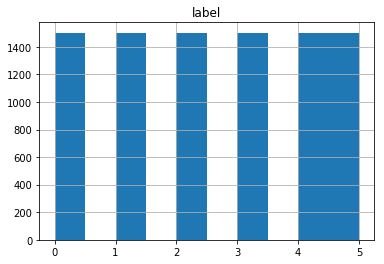

In [48]:
# create a dataframe from the pixel coordinates
df = pd.DataFrame(pixel_coords)
df.hist(column="label")

In [49]:
landsat_datasets["029011"][0].crs

CRS.from_wkt('PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]')

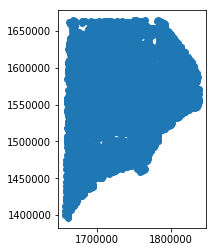

In [50]:
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.x, df.y), crs=landsat_datasets["028011"][0].crs)
gdf.plot()

In [51]:
# buffer by 15 meters to make 30x30 pixel
buffer = gdf.buffer(15)

envelope = buffer.envelope  
gdf.geometry = envelope
gdf.head()

,canopy,label,tile_name,x,y,geometry
0,0.0,0,028011,1783740.0,1635480.0,"POLYGON ((1783725 1635465, 1783755 1635465, 17..."
1,0.0,0,029011,1822440.0,1598430.0,"POLYGON ((1822425 1598415, 1822455 1598415, 18..."
2,0.0,0,029011,1798290.0,1579380.0,"POLYGON ((1798275 1579365, 1798305 1579365, 17..."
3,0.0,0,028012,1751790.0,1475280.0,"POLYGON ((1751775 1475265, 1751805 1475265, 17..."
4,0.0,0,029011,1829640.0,1545630.0,"POLYGON ((1829625 1545615, 1829655 1545615, 18..."


In [52]:
gdf = gdf.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
gdf.head()

,canopy,label,tile_name,x,y,geometry
0,0.0,0,028011,1783740.0,1635480.0,POLYGON ((-75.86736105150854 36.06319781040016...
1,0.0,0,029011,1822440.0,1598430.0,POLYGON ((-75.53253728043329 35.66656089362623...
2,0.0,0,029011,1798290.0,1579380.0,POLYGON ((-75.84033753004364 35.54602683335875...
3,0.0,0,028012,1751790.0,1475280.0,POLYGON ((-76.58199946402259 34.72172447001045...
4,0.0,0,029011,1829640.0,1545630.0,POLYGON ((-75.57961009781188 35.19198272134367...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d9ba7e4e0>]],
      dtype=object)

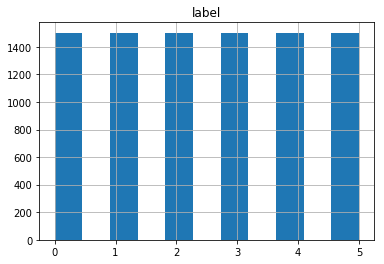

In [53]:
gdf.hist(column="label", bins=11)

In [54]:
gdf.to_file("buffered_points.shp",driver='ESRI Shapefile')

In [127]:
reopened_gdf = gpd.read_file("buffered_points.shp")
reopened_gdf.head()

,canopy,label,tile_name,x,y,geometry
0,0.0,0,028012,1761360.0,1488030.0,POLYGON ((-76.45020728592766 34.81590242273489...
1,0.0,0,028011,1681560.0,1662390.0,POLYGON ((-76.92900325896298 36.48521077384399...
2,0.0,0,028012,1716840.0,1502310.0,POLYGON ((-76.89957784087977 35.02127890428567...
3,0.0,0,028012,1755480.0,1474380.0,POLYGON ((-76.54424306552457 34.70714544743746...
4,0.0,0,028011,1746030.0,1604430.0,POLYGON ((-76.35222097208796 35.86193505990429...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ebdeba320>]],
      dtype=object)

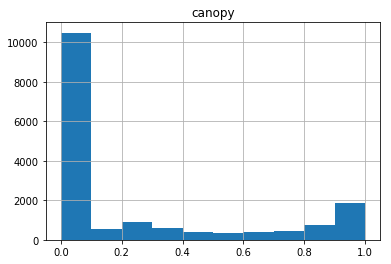

In [146]:
reopened_gdf.hist(column="canopy")

In [130]:
reopened_gdf.crs

{'init': 'epsg:4326'}

In [133]:
reopened_gdf.head()

,canopy,label,tile_name,x,y,geometry
0,0.0,0,028012,1761360.0,1488030.0,POLYGON ((-76.45020728592766 34.81590242273489...
1,0.0,0,028011,1681560.0,1662390.0,POLYGON ((-76.92900325896298 36.48521077384399...
2,0.0,0,028012,1716840.0,1502310.0,POLYGON ((-76.89957784087977 35.02127890428567...
3,0.0,0,028012,1755480.0,1474380.0,POLYGON ((-76.54424306552457 34.70714544743746...
4,0.0,0,028011,1746030.0,1604430.0,POLYGON ((-76.35222097208796 35.86193505990429...


In [144]:
for index, row in df.iterrows():
    print(row['tile_name'])
    print(row['canopy'])
    print(row['geometry'])
    print(row['geometry'].centroid)
    break

028012
0.0
POLYGON ((1761345 1488015, 1761375 1488015, 1761375 1488045, 1761345 1488045, 1761345 1488015))
POINT (1761360 1488030)


In [148]:
pd.cut(reopened_gdf['canopy'], 10).value_counts().sort_index()

(-0.001, 0.1]    10490
(0.1, 0.2]         625
(0.2, 0.3]         827
(0.3, 0.4]         656
(0.4, 0.5]         417
(0.5, 0.6]         312
(0.6, 0.7]         376
(0.7, 0.8]         502
(0.8, 0.9]         779
(0.9, 1.0]        1757
Name: canopy, dtype: int64